In [19]:
import os, shutil
import tensorflow as tf



In [20]:
original_dataset_dir = '/Users/melathaile/Desktop/ResNet/img/train'

In [21]:
os.listdir('/Users/melathaile/Desktop/ResNet/img/train')

['Urticaria Hives',
 'Seborrheic Keratoses and other Benign Tumors',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Acne and Rosacea Photos',
 'Vascular Tumors',
 'Eczema Photos',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Exanthems and Drug Eruptions',
 'Lupus and other Connective Tissue diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Bullous Disease Photos',
 'Nail Fungus and other Nail Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Systemic Disease',
 'Light Diseases and Disorders of Pigmentation',
 'Atopic Dermatitis Photos',
 'Warts Molluscum and other Viral Infections',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Melanoma Skin Cancer Nevi and Moles',
 'Vasculitis Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos']

In [22]:
import numpy as np
import pandas as pd

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#from tensorflow.keras.applications.vgg16 import  preprocess_input
from tensorflow.keras.applications.resnet import  preprocess_input

In [24]:
img_width, img_height = 256, 256

In [25]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [26]:
res = preprocess_image("/Users/melathaile/Desktop/ResNet/img/train/Acne and Rosacea Photos/07Acne081101.jpg")
print(res)

[[[[ 8.0609970e+00  4.2210007e+00  3.1320000e+01]
   [ 1.1060997e+01  4.2210007e+00  3.2320000e+01]
   [ 1.2060997e+01  3.2210007e+00  3.1320000e+01]
   ...
   [ 5.0609970e+00 -7.7899933e-01  3.1320000e+01]
   [ 1.0609970e+00 -4.7789993e+00  2.7320000e+01]
   [ 1.4060997e+01  8.2210007e+00  4.0320000e+01]]

  [[ 1.3060997e+01  9.2210007e+00  3.6320000e+01]
   [ 1.8060997e+01  1.1221001e+01  3.9320000e+01]
   [ 2.5060997e+01  1.6221001e+01  4.4320000e+01]
   ...
   [ 1.3060997e+01  7.2210007e+00  3.9320000e+01]
   [ 9.0609970e+00  3.2210007e+00  3.5320000e+01]
   [-9.3900299e-01 -8.7789993e+00  2.3320000e+01]]

  [[ 1.2060997e+01  8.2210007e+00  3.5320000e+01]
   [ 1.7060997e+01  1.0221001e+01  3.8320000e+01]
   [ 1.7060997e+01  8.2210007e+00  3.6320000e+01]
   ...
   [ 6.0997009e-02 -7.7789993e+00  2.4320000e+01]
   [ 1.2060997e+01  5.2210007e+00  3.5320000e+01]
   [ 2.3060997e+01  1.3221001e+01  4.4320000e+01]]

  ...

  [[ 1.0609970e+00 -2.7789993e+00  2.7320000e+01]
   [ 7.0609970e+

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

HEIGHT = 300
WIDTH = 300

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "/Users/melathaile/Desktop/ResNet/img/train"
HEIGHT = 300
WIDTH = 300
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        '/Users/melathaile/Desktop/ResNet/img/train',
        target_size=(300, 300),
        batch_size=BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 15557 images belonging to 23 classes.


In [29]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = os.listdir("/Users/melathaile/Desktop/ResNet/img/train")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

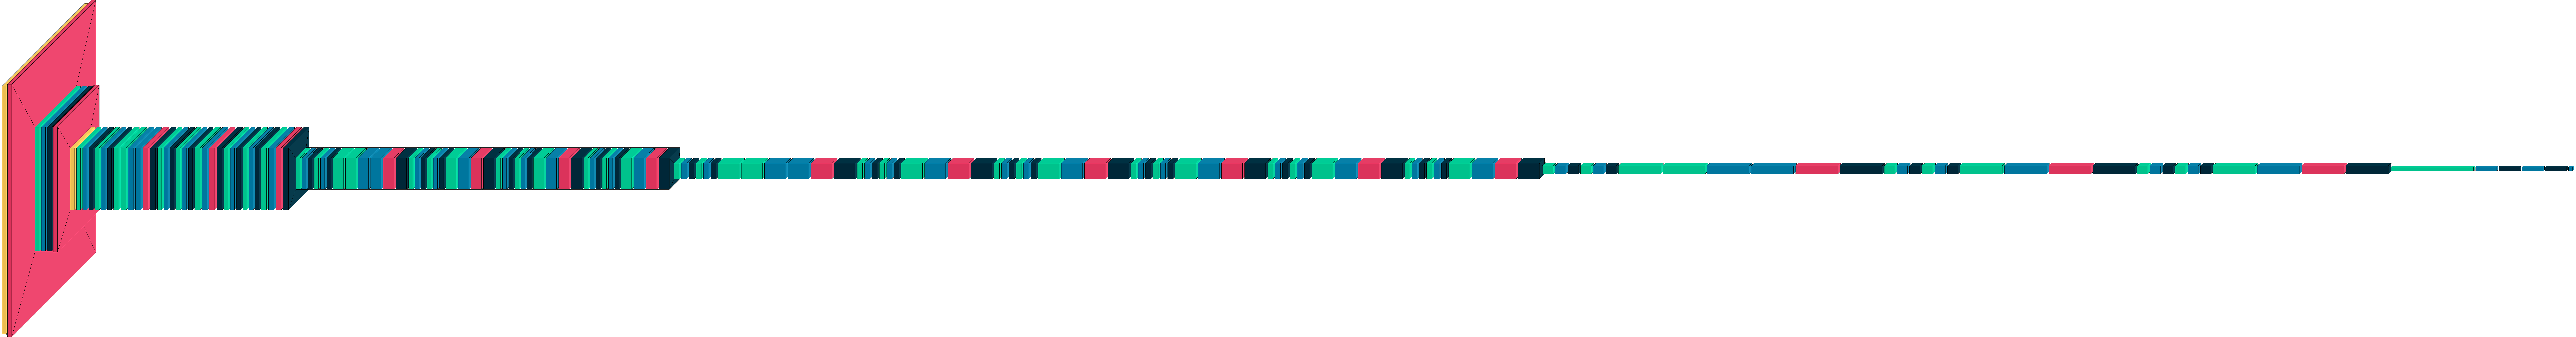

In [30]:
import visualkeras
visualkeras.layered_view(finetune_model)

In [31]:
layer_names = [layer.name for layer in finetune_model.layers]
layer_names

['input_2',
 'conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 500
BATCH_SIZE = 20
num_train_images = 15557

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, workers=16, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list)